# Reciprocity and sensitivity kernels for sea level fingerprints

This notebook illustrates the reciprocity relations discussed in the paper by Al-Attar *et al.* (2023)
of the same name which has been submitted to GJI. In particular, this notebook includes code used to generate 
all the figures included within that paper. You can also run the python script MakeFigures.py which makes and saves the figures in a chosen directory.



In [1]:
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyshtools as pysh
import SLmod as SL
import RFmod as RF
from numpy import pi as pi


#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]


# get values for some physical parameters
b = SL.b
g = SL.g
G = SL.G
rhoi = SL.rhoi
rhow = SL.rhow
rhos = SL.rhos

Now we read in the present day distribution of sea level and ice. This is taken from the ice6g model of:

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176

The values of the fields are interpolated onto a Gauss Legendre grid at the chosen expansion order. Note that for the calculations in this notebook L = 256 or higher is a sensible value. The maximum possible is L = 4096, this being set by the Love numbers that have been pre-calculated and are read in below. 

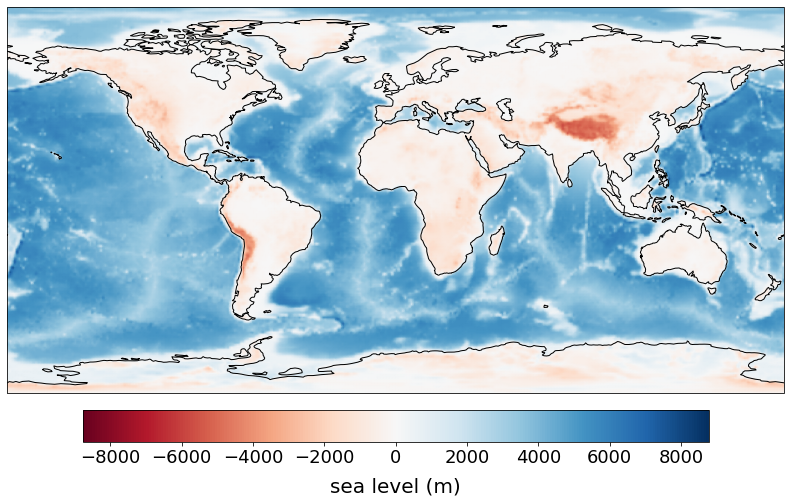

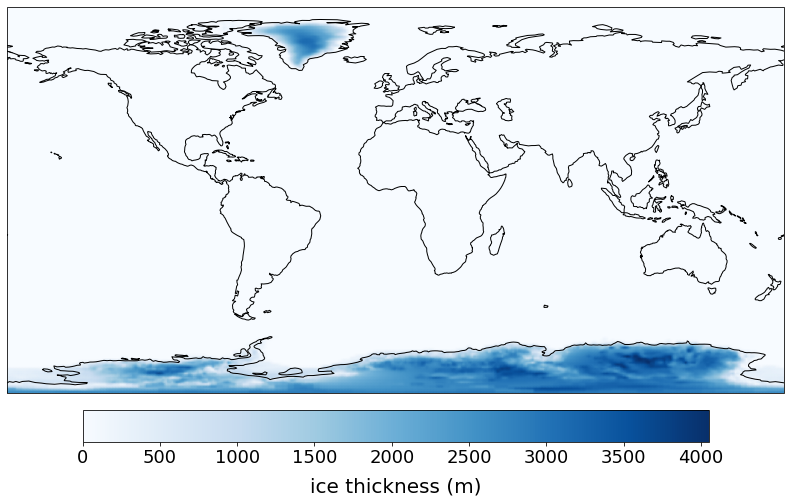

fraction of surface which is ocean =  0.7118907012236343


In [2]:
# set the truncation degree
L=256

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)

# plot these fields
SL.plot(sl0,label = 'sea level (m)')
SL.plot(ice0,label = 'ice thickness (m)',clim_pos = True)

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

# work out the ocean area and check the value
A = SL.surface_integral(C)
A_earth = 4*pi*b**2
print('fraction of surface which is ocean = ',A/A_earth)


## Solving the sea level equation to make a synthetic data set


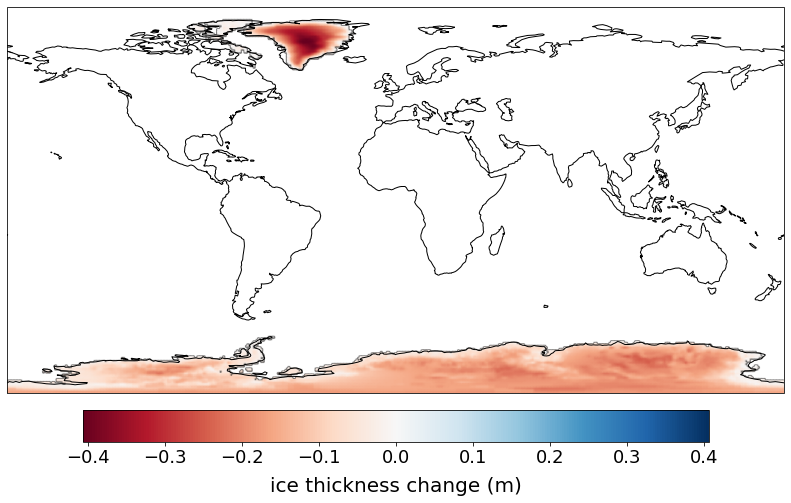

iteration =  1 relative change =  0.046665685760126974
iteration =  2 relative change =  0.005987902241255517
iteration =  3 relative change =  0.0010645011266018514
iteration =  4 relative change =  0.00021381269277048114
iteration =  5 relative change =  4.683153394893926e-05
iteration =  6 relative change =  1.1025460675915513e-05
iteration =  7 relative change =  2.769079746672699e-06
iteration =  8 relative change =  7.370992047657761e-07
iteration =  9 relative change =  2.0640217178711006e-07
iteration =  10 relative change =  6.023616711520706e-08
iteration =  11 relative change =  1.8143187091649106e-08
iteration =  12 relative change =  5.591365776754175e-09


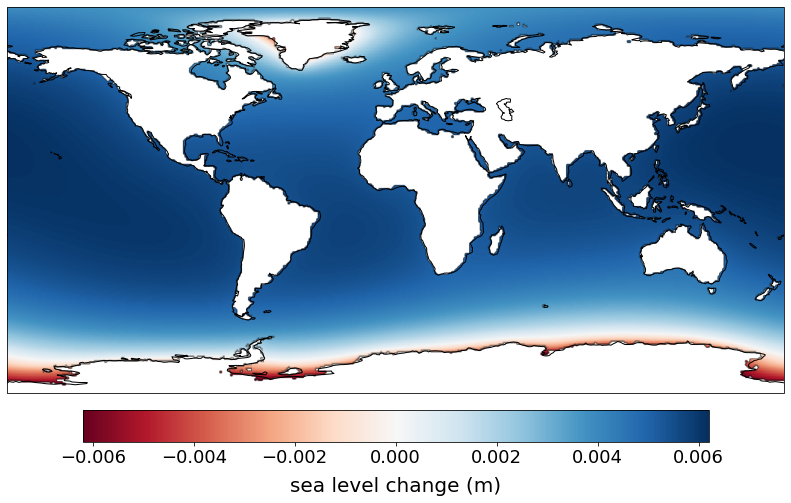

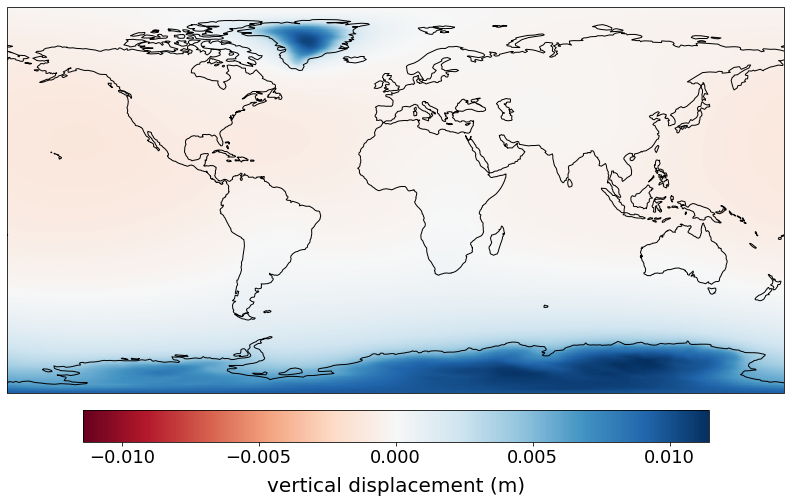

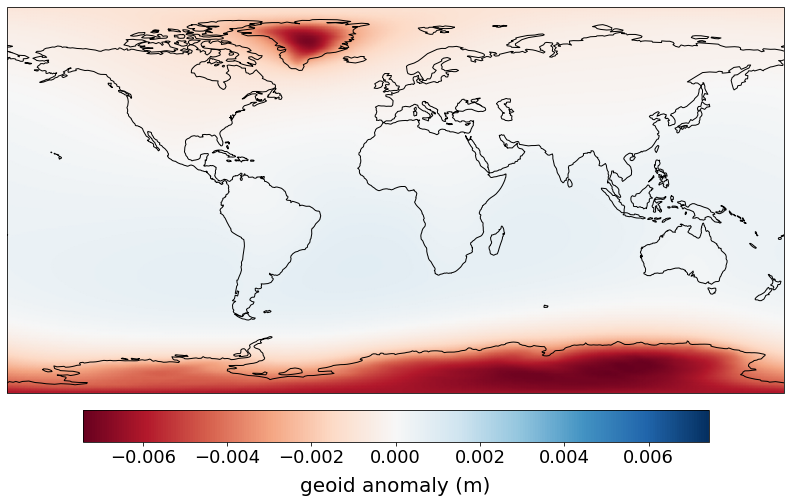

In [8]:
# set to true to use a random ice change model
use_random = False

if(use_random):
    Q = RF.sobolev_covariance(L,s = 2,mu = 0.2, b = b)
    zeta_north = -rhoi*SL.greenland_mask(sl0,ice0,val = 0.)*RF.random_field(Q, b = b)
    zeta_south = -rhoi*SL.antarctica_mask(sl0,ice0,val = 0.)*RF.random_field(Q, b = b)
else:
    zeta_north = -rhoi*SL.zero_southern_hemisphere(ice0)
    zeta_south = -rhoi*SL.zero_northern_hemisphere(ice0)
        
    
# normalise by GMSL contributions
GMSL_north = SL.bathtub(C,zeta_north)
GMSL_south = SL.bathtub(C,zeta_south)
zeta_north /= GMSL_north
zeta_south /= GMSL_south

# set the rate of GMSL change in mm
GMSL = 0.005

# set the northern and southern fractions
f_north = 0.2
f_south = 1.-f_north

# set the combined ice load
zeta = GMSL*(f_north*zeta_north + f_south*zeta_south)

# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*zeta/SL.rhoi,label = r'ice thickness change (m)')

# solve the fingerprint problem
sl,u,phi,om,psi = SL.fingerprint(C,zeta)
ocean_mask = SL.ocean_mask(sl0,ice0)

# plot the result globally
SL.plot(ocean_mask*sl,label = r'sea level change (m)')
SL.plot(u,label = r'vertical displacement (m)')
SL.plot(-1*phi/g,label = r'geoid anomaly (m)')



## Sensitivity kernel for sea level at a given location


iteration =  1 relative change =  0.007498751146103031
iteration =  2 relative change =  0.0002832209368633219
iteration =  3 relative change =  3.583549621191926e-05
iteration =  4 relative change =  7.01818316810871e-06
iteration =  5 relative change =  1.530336846492725e-06
iteration =  6 relative change =  3.594346923909825e-07
iteration =  7 relative change =  9.047590290107059e-08
iteration =  8 relative change =  2.4282234779033007e-08
iteration =  9 relative change =  6.950616430359786e-09


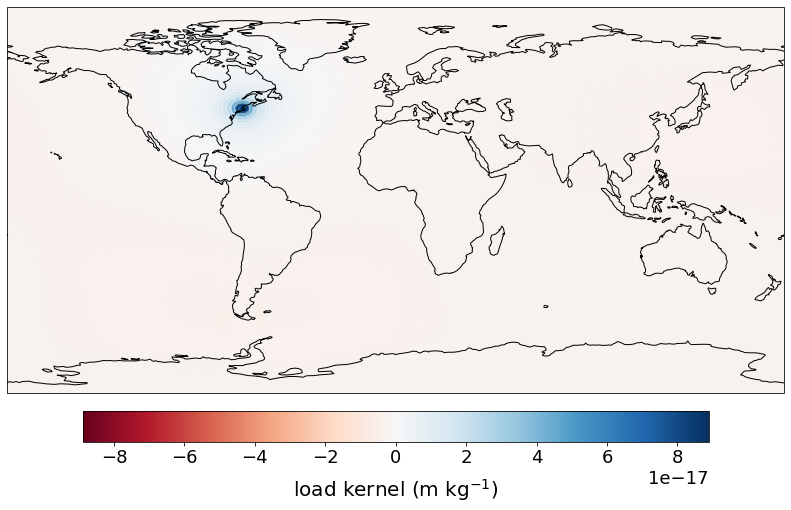

direct sea level value =  0.004618165037407445
left hand side         =  0.004618165037407452
right hand side        =  0.0046181657974589015
relative difference    =  1.6457866784153024e-07


In [9]:
# set the observation point to Boston
lat =  42.3601
lon = -71.0589


# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 0.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)',clim_scale = 0.1)


# set the value of sea level directly from the field 
sl_direct = SL.point_evaluation(sl,lat,lon)

# evaluate the sea level by integration against the delta load
lhs = SL.surface_integral(zeta_d*sl)

# now get the value by integrating the sensitivity kernel against the direct load
rhs = SL.surface_integral(sl_d*zeta)

# print the values out along with the relative difference
print('direct sea level value = ',sl_direct)
print('left hand side         = ',lhs)
print('right hand side        = ',rhs)
print('relative difference    = ', np.abs((lhs-rhs)/lhs))


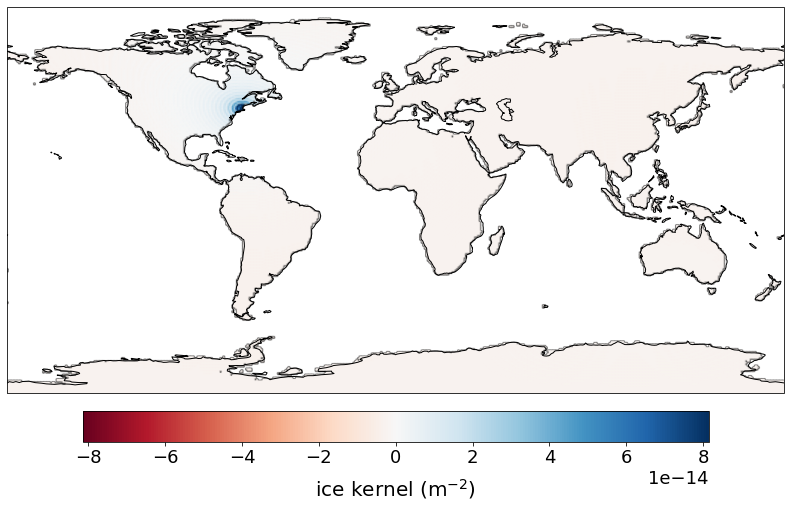

In [10]:
# define and plot the sensitivity kernel with respect to ice thickness
K = SL.rhoi*(1-C)*sl_d
land_mask = SL.land_mask(sl0,ice0)
SL.plot(land_mask*K,label = r'ice kernel (m$^{-2}$)',clim_scale = 0.1)

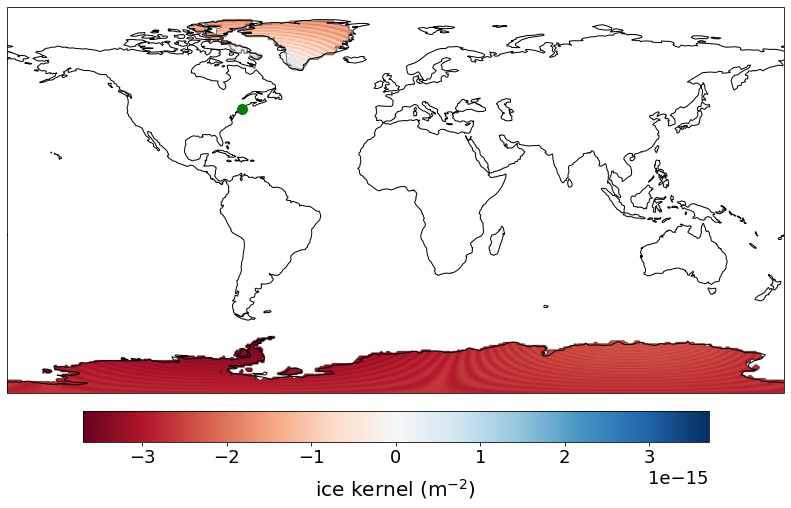

In [11]:
# re-define the kernel such that it is non-zero only where there is grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

iteration =  1 relative change =  0.013156394692021347
iteration =  2 relative change =  0.0005963222416013993
iteration =  3 relative change =  7.416965948410276e-05
iteration =  4 relative change =  1.4487795971970605e-05
iteration =  5 relative change =  3.156279007126248e-06
iteration =  6 relative change =  7.408105205033747e-07
iteration =  7 relative change =  1.8636060911661412e-07
iteration =  8 relative change =  4.9989090825247605e-08
iteration =  9 relative change =  1.4296439090998618e-08
iteration =  10 relative change =  4.369973802146108e-09


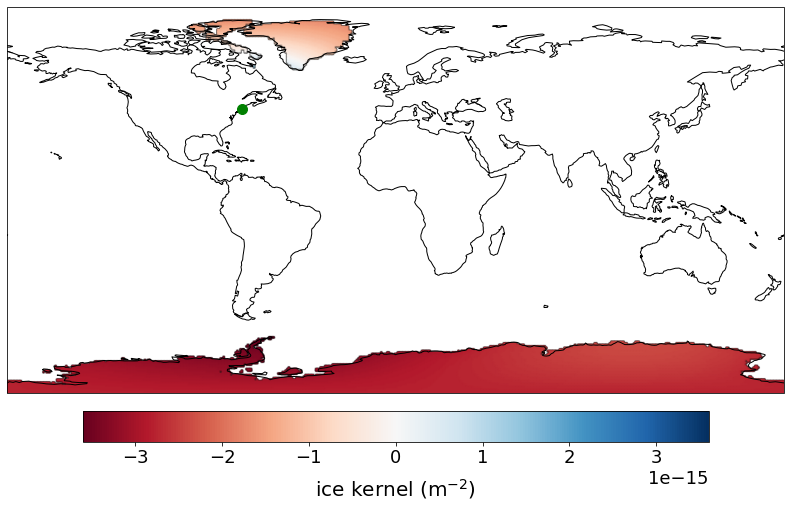

In [12]:
# compute the adjoint load for a SMOOTHED point load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)

# set and plot the kernel projected onto regions of grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])


## Sensitivity kernel for vertical displacement measurement



iteration =  1 relative change =  0.003308446600756538
iteration =  2 relative change =  0.00019128373103146547
iteration =  3 relative change =  2.066306072847974e-05
iteration =  4 relative change =  2.960245826284915e-06
iteration =  5 relative change =  5.53555572308954e-07
iteration =  6 relative change =  1.3522787586549e-07
iteration =  7 relative change =  3.544455465991089e-08
iteration =  8 relative change =  9.879143073403483e-09

direct displacement value =  0.0008797136318130379
left hand side            =  0.0008797142100160773
right hand side           =  0.0008797136318130443
relative difference       =  6.572623545186269e-07

iteration =  1 relative change =  0.009381310431370563
iteration =  2 relative change =  0.0004474541275053134
iteration =  3 relative change =  4.612763201980701e-05
iteration =  4 relative change =  6.59422732792914e-06
iteration =  5 relative change =  1.160491390168546e-06
iteration =  6 relative change =  2.8246137536243197e-07
iteration =  7

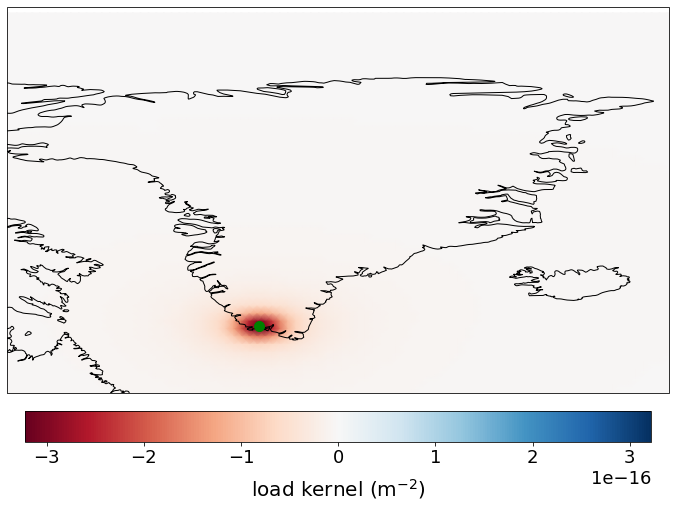

In [13]:
# set the observation point at SENU GPS station in Greenland
#lat = 40.6401
#lon = 22.9444

lat = 61.0696
lon = -47.1413

zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',xlim = [-70,-10],ylim = [55,90],marker = [lat,lon])

iteration =  1 relative change =  0.004580023698925666
iteration =  2 relative change =  0.00022868734106418104
iteration =  3 relative change =  2.735631527390893e-05
iteration =  4 relative change =  4.439409945214563e-06
iteration =  5 relative change =  8.51473598449167e-07
iteration =  6 relative change =  1.7463035254888548e-07
iteration =  7 relative change =  3.748960321988027e-08
iteration =  8 relative change =  8.528780537752693e-09

direct displacement value =  0.0019243226278996164
left hand side            =  0.0019243226863988874
right hand side           =  0.0019243226278996173
relative difference       =  3.0399927471445556e-08

iteration =  1 relative change =  0.010801470782791723
iteration =  2 relative change =  0.0005564281299002032
iteration =  3 relative change =  6.35515063330138e-05
iteration =  4 relative change =  1.0220473335241837e-05
iteration =  5 relative change =  1.9506083638868816e-06
iteration =  6 relative change =  3.999943802526812e-07
iteration

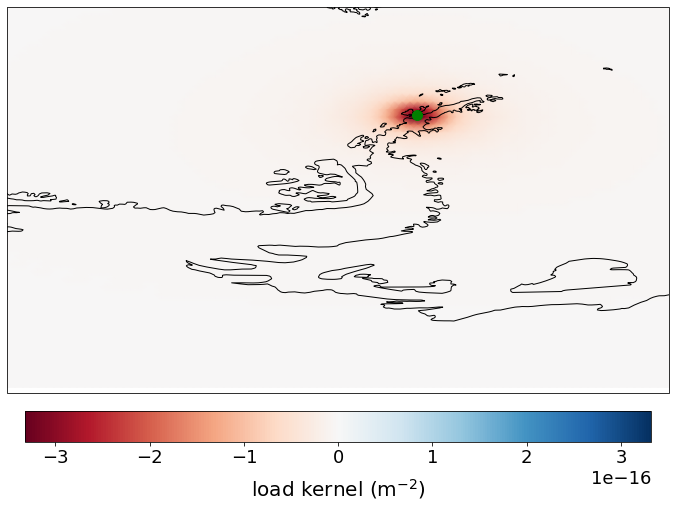

In [14]:
# set the observation point BLAS GPS station in Greeland
#lat = -37.8136
#lon = -22.9747

lat = -64.80495000
lon = -62.81690000

zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',marker = [lat,lon],xlim = [-100,-40],ylim = [-90,-55])

## Sensitivity kernel for gravitational potential coefficient measurement


iteration =  1 relative change =  0.12121762602298224
iteration =  2 relative change =  0.014917298647378181
iteration =  3 relative change =  0.001967597361395151
iteration =  4 relative change =  0.00032158202062867867
iteration =  5 relative change =  6.016933929220035e-05
iteration =  6 relative change =  1.2780128436953225e-05
iteration =  7 relative change =  3.3029094611800475e-06
iteration =  8 relative change =  9.059333573279534e-07
iteration =  9 relative change =  2.5168873963023765e-07
iteration =  10 relative change =  7.164815619468399e-08
iteration =  11 relative change =  2.0952358478947745e-08
iteration =  12 relative change =  6.282473129281786e-09

direct potential value    =  -0.001427966180785797
left hand side            =  -0.0014279661245927093
right hand side           =  -0.001427966180785796
relative difference       =  3.935183452492841e-08



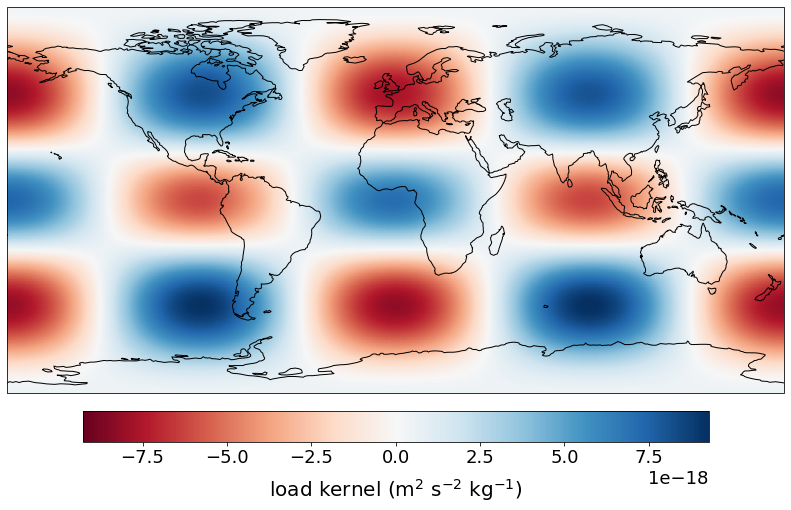

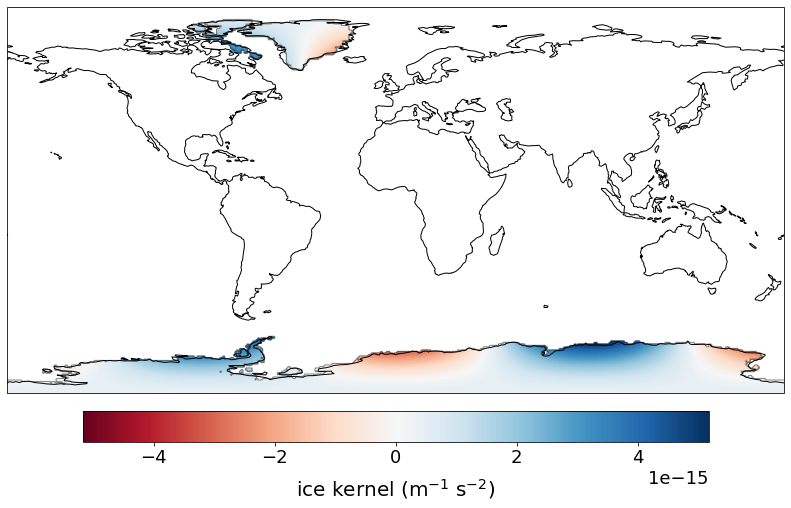

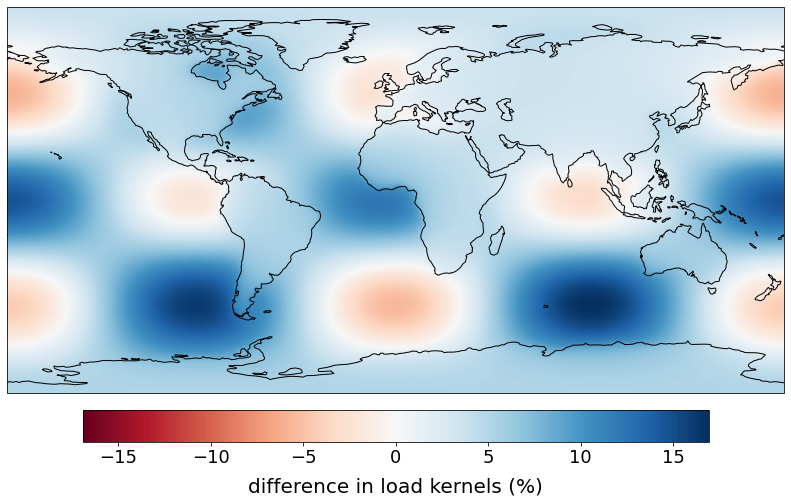

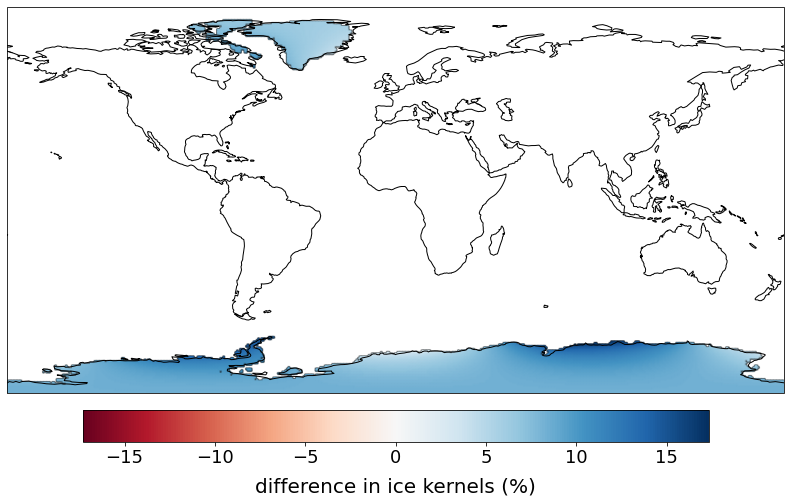

In [15]:
# set the adjoint loads
l = 4
m = 2
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)')


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)')


iteration =  1 relative change =  0.04262237639154877
iteration =  2 relative change =  0.0021600920184973575
iteration =  3 relative change =  0.00014986571474822236
iteration =  4 relative change =  1.6265090104205663e-05
iteration =  5 relative change =  2.6719634496652638e-06
iteration =  6 relative change =  5.255439042269298e-07
iteration =  7 relative change =  1.1600389989272978e-07
iteration =  8 relative change =  2.7395941848597477e-08
iteration =  9 relative change =  6.849698256908909e-09

direct potential value    =  0.0005184131572048067
left hand side            =  0.0005184131490992269
right hand side           =  0.0005184131572048069
relative difference       =  1.5635367319202846e-08



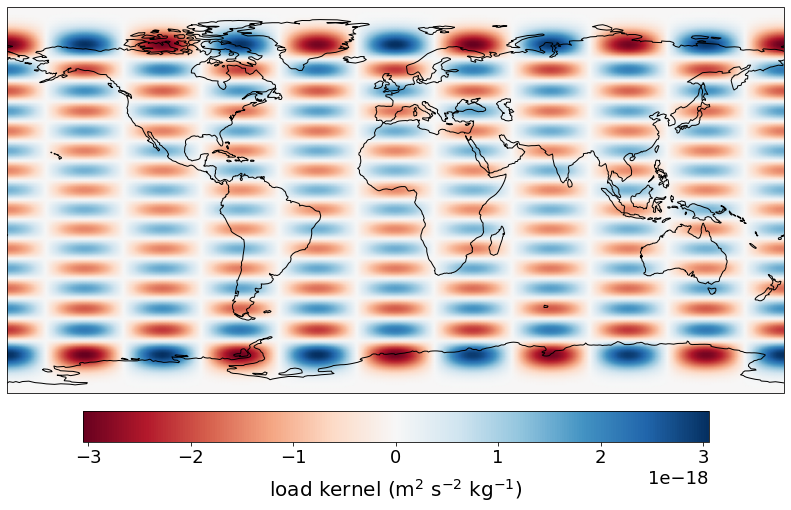

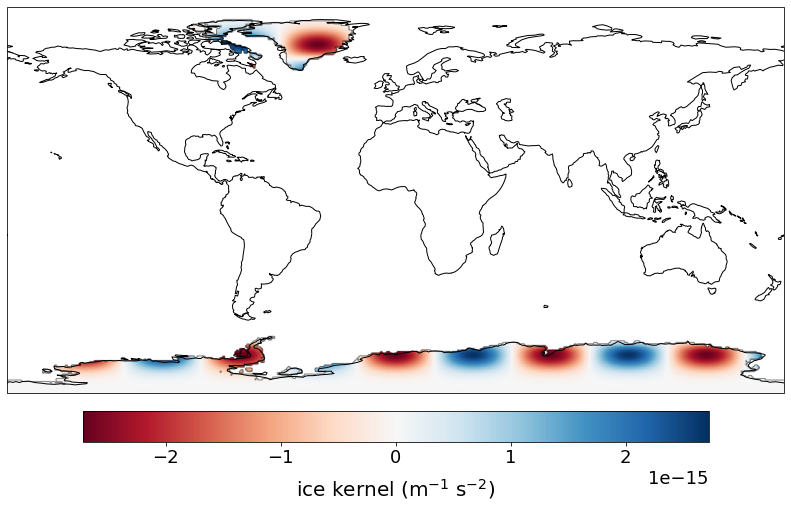

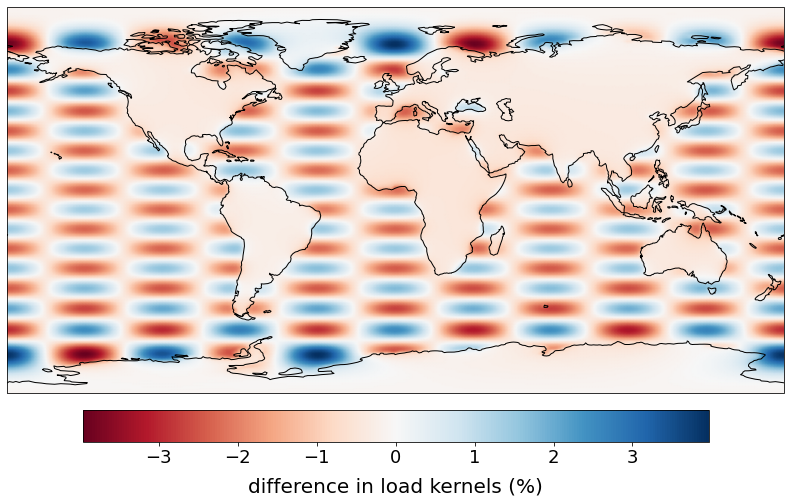

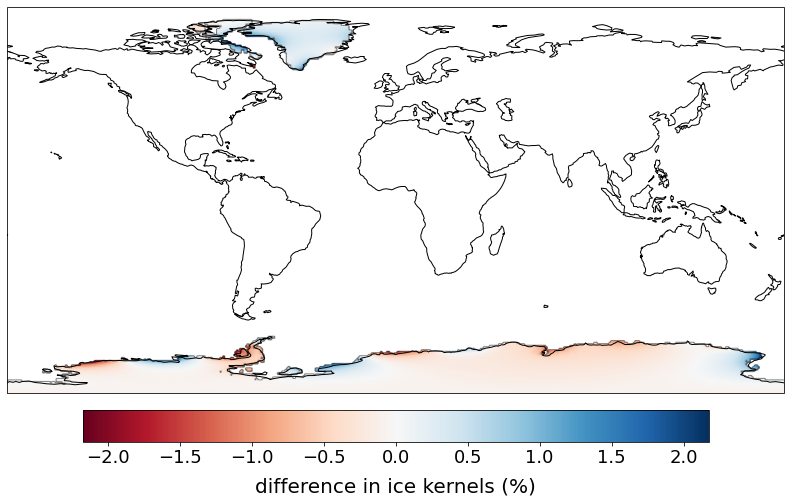

In [16]:
# set the adjoint loads for a higher degree
l = 20
m = 5
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)')


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)')


## Sensitivity kernels for Grace load averages

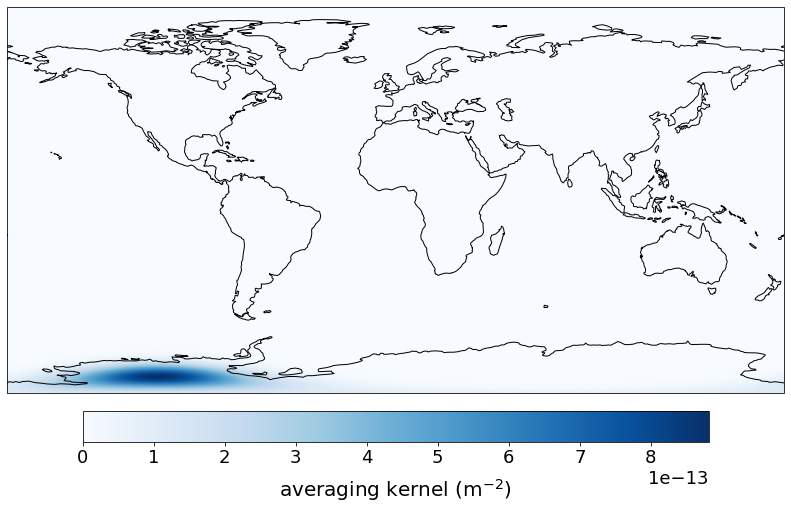

iteration =  1 relative change =  0.005766463104455943
iteration =  2 relative change =  0.00019557091615161282
iteration =  3 relative change =  3.834785921378352e-05
iteration =  4 relative change =  7.652485675563547e-06
iteration =  5 relative change =  1.545304964363549e-06
iteration =  6 relative change =  3.150286858907276e-07
iteration =  7 relative change =  6.511757402046728e-08
iteration =  8 relative change =  1.386041258806028e-08
iteration =  9 relative change =  3.811853212500741e-09

left hand side            =  -82.30354490940573
right hand side           =  -82.3035515028549
relative difference       =  8.011136311066691e-08



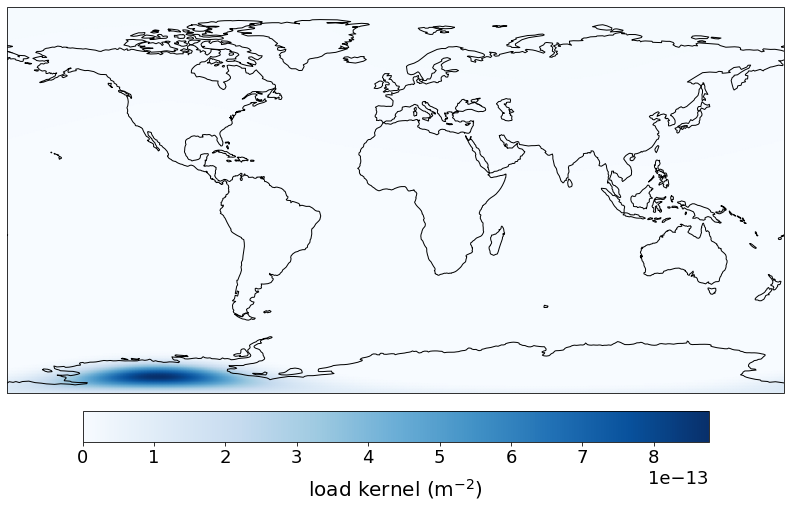

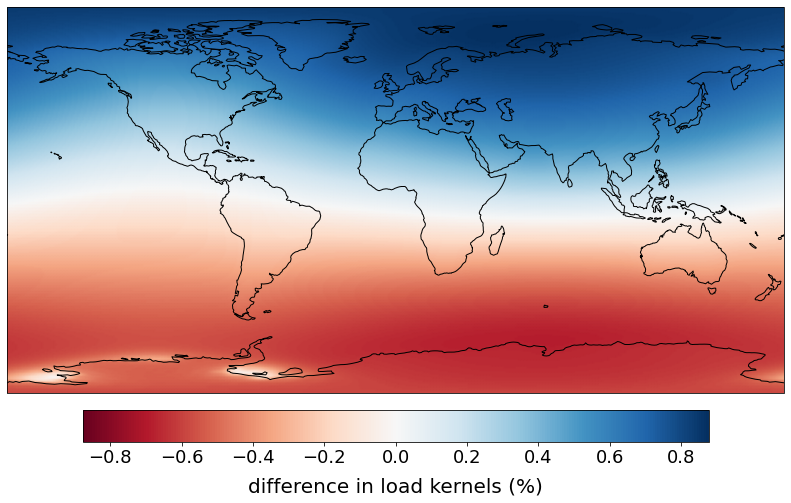

GRACE average of load =  -0.08230355150285484
average of direct load  =  -0.08777112319071054
relative difference with direct load average   =  -6.229351396102866 %
iteration =  1 relative change =  0.005766463104455406
iteration =  2 relative change =  0.00019557091615160627
iteration =  3 relative change =  3.834785921380055e-05
iteration =  4 relative change =  7.652485675556513e-06
iteration =  5 relative change =  1.5453049643635824e-06
iteration =  6 relative change =  3.1502868588353343e-07
iteration =  7 relative change =  6.51175740204687e-08
iteration =  8 relative change =  1.3860412585360196e-08
iteration =  9 relative change =  3.811853181896477e-09


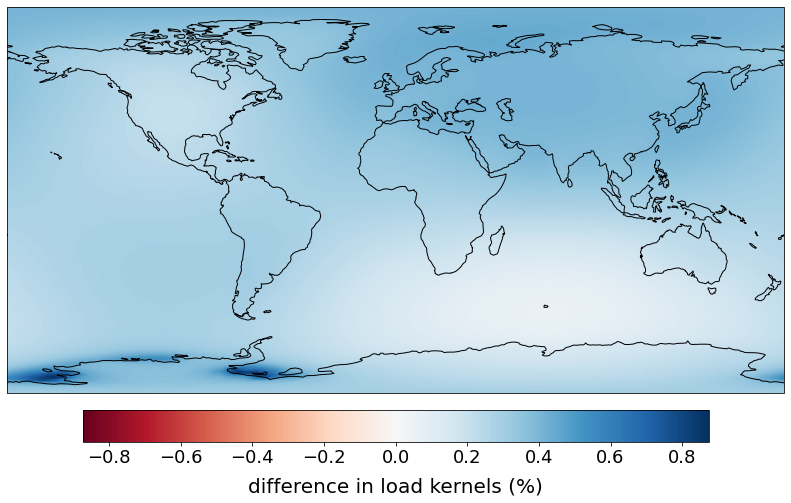

GRACE average of load =  -0.08230355150285348
average of direct load  =  -0.07814233552120237
relative difference with direct load average   =  5.325174828594744 %


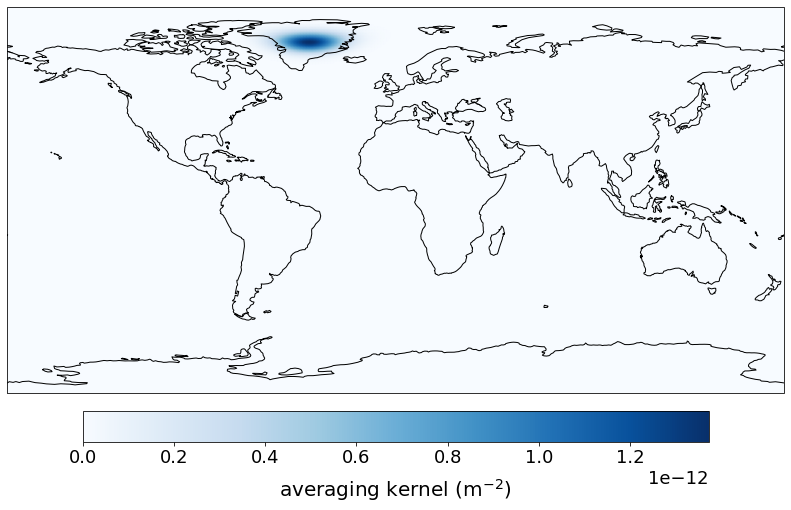

iteration =  1 relative change =  0.005044435805904598
iteration =  2 relative change =  0.00021020803266510828
iteration =  3 relative change =  4.67056741794852e-05
iteration =  4 relative change =  1.080789073742333e-05
iteration =  5 relative change =  2.618326614020036e-06
iteration =  6 relative change =  6.664813502734723e-07
iteration =  7 relative change =  1.782531236189022e-07
iteration =  8 relative change =  4.989877143168774e-08
iteration =  9 relative change =  1.4520608954397843e-08
iteration =  10 relative change =  4.358042495500829e-09

left hand side            =  -213.8834462437737
right hand side           =  -213.88345109667827
relative difference       =  2.2689481829072623e-08



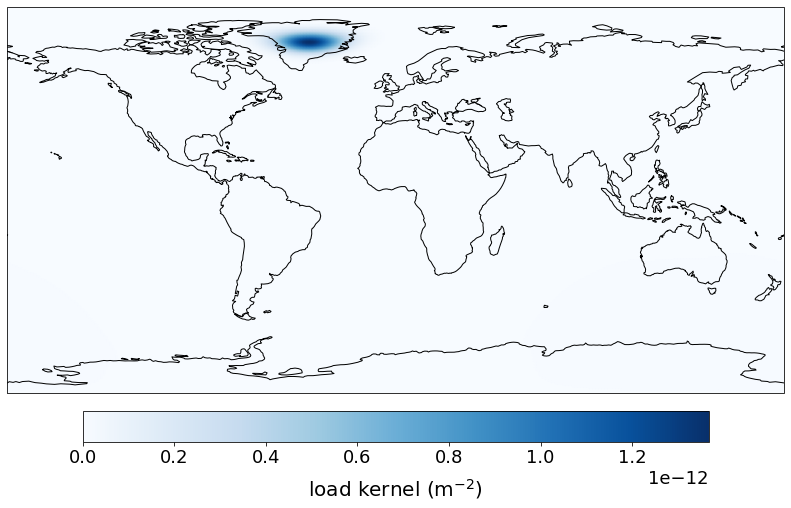

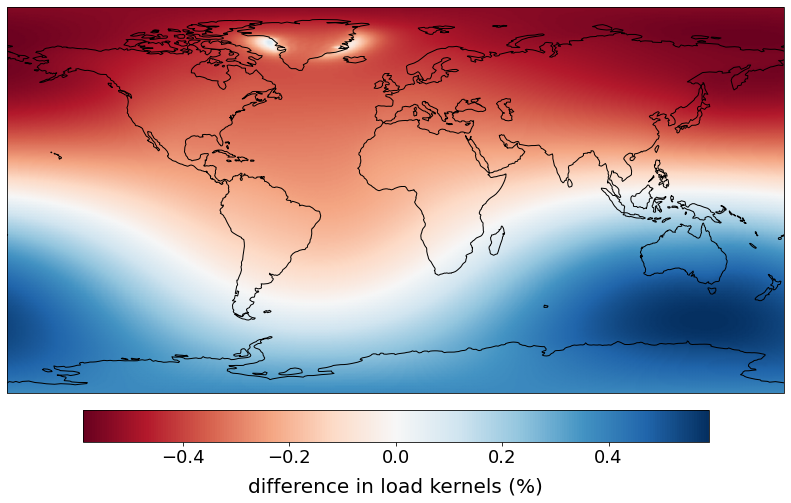

GRACE average of load =  -0.2138834510966786
average of direct load  =  -0.20768776990771678
relative difference with direct load average   =  2.9831709357343446 %
iteration =  1 relative change =  0.00504443580590483
iteration =  2 relative change =  0.00021020803266510408
iteration =  3 relative change =  4.670567417948991e-05
iteration =  4 relative change =  1.080789073742797e-05
iteration =  5 relative change =  2.6183266140246603e-06
iteration =  6 relative change =  6.664813502607704e-07
iteration =  7 relative change =  1.7825312362121224e-07
iteration =  8 relative change =  4.989877143399752e-08
iteration =  9 relative change =  1.4520608948623667e-08
iteration =  10 relative change =  4.3580425001202005e-09


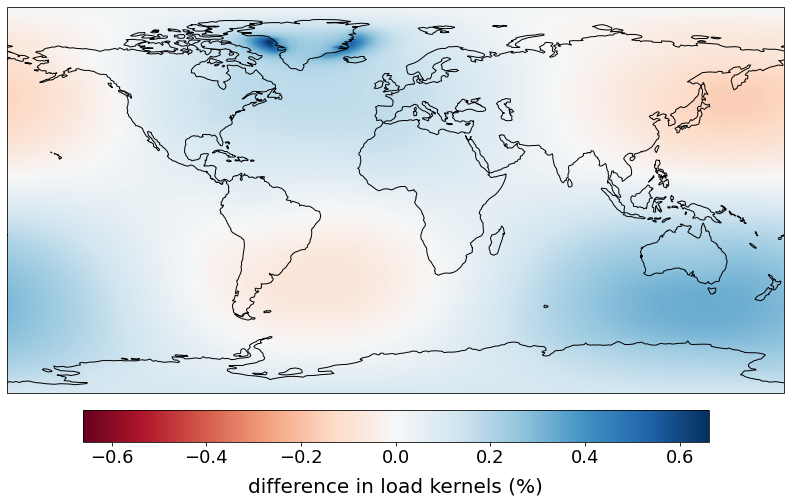

GRACE average of load =  -0.21388345109667867
average of direct load  =  -0.2100797080177035
relative difference with direct load average   =  1.8106189859396677 %


In [39]:
# truncation degree for GRACE average (LT = 0 means no truncation)
LT = 100

# define the averaging function as in Wahr et al. (1998) targeted at W. Antarctic
w = SL.gaussian_averaging_function(L,r = 500,lat0 = -82.,lon0 = -110.,cut = False)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)',clim_pos = True)

# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',cmap = "Blues",clim_pos = True)

GRACE_average = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow

# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)',clim_sym = True)

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')

# Repeat with l <= 1 removed from weight function
w = SL.gaussian_averaging_function(L,r = 500,lat0 = -82.,lon0 = -110.,cut = True)
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
GRACE_average = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)',clim_sym = True)
print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')



##########################################################
# now do the same thing but for a Greenland average

# define the averaging function as in Wahr et al. (1998) targeted at Greenland
w = SL.gaussian_averaging_function(L,r = 400,lat0 = 73.,lon0 = -40.,cut = False)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)',clim_pos = True)


# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',clim_pos = True)

GRACE_average      = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow


# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)')

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')
# Repeat with l <=1 removed from weight function
w = SL.gaussian_averaging_function(L,r = 400,lat0 = 73.,lon0 = -40.,cut = True)
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
GRACE_average      = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)')
print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')



## Case 4: Sensitivity kernels for sea surface height

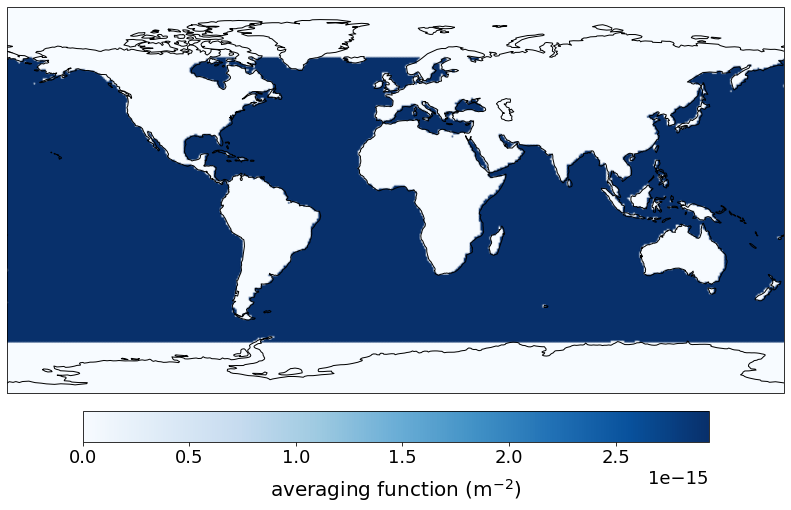

iteration =  1 relative change =  0.009431655356331316
iteration =  2 relative change =  0.0018000596990000027
iteration =  3 relative change =  0.0003989903053466987
iteration =  4 relative change =  8.921379159333109e-05
iteration =  5 relative change =  2.0150644050968456e-05
iteration =  6 relative change =  4.60544617233634e-06
iteration =  7 relative change =  1.0668542844116907e-06
iteration =  8 relative change =  2.5107664481194323e-07
iteration =  9 relative change =  6.022232144211199e-08
iteration =  10 relative change =  1.4776734372843495e-08
iteration =  11 relative change =  3.722634152671196e-09

direct ssh value     =  0.0048974615020405034
left hand side       =  0.004897461458590715
right hand side      =  0.004897461502040504
relative difference  =  8.87190012071984e-09



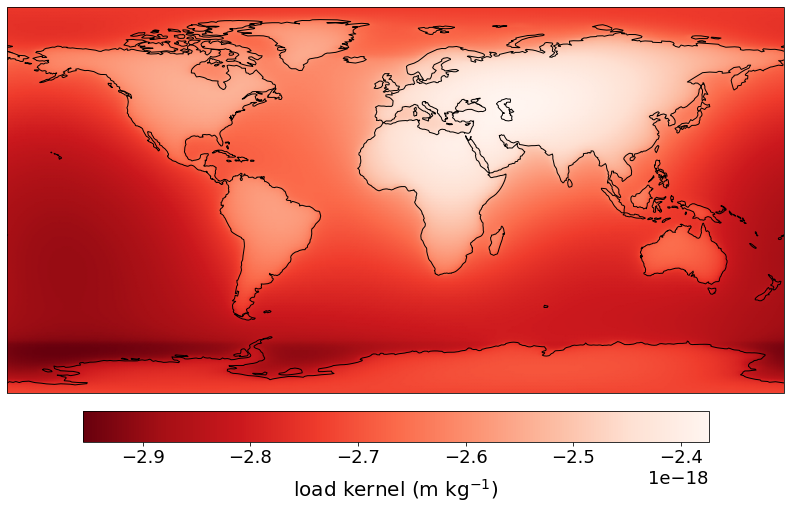

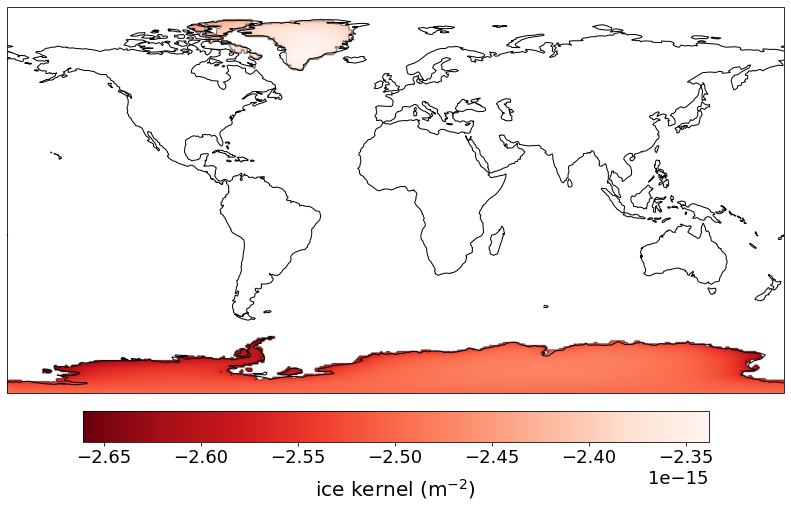

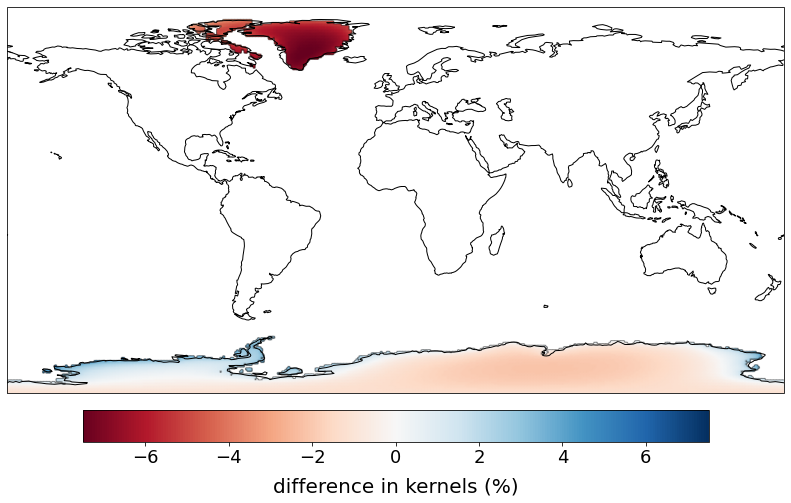

percentage difference from GMSL =  -2.050769959189933 %

iteration =  1 relative change =  0.020810035129174745
iteration =  2 relative change =  0.0025168834371969615
iteration =  3 relative change =  0.0004218633492614692
iteration =  4 relative change =  8.333842199020502e-05
iteration =  5 relative change =  1.8143839733415343e-05
iteration =  6 relative change =  4.260186601360209e-06
iteration =  7 relative change =  1.0734379299108167e-06
iteration =  8 relative change =  2.8867774252608256e-07
iteration =  9 relative change =  8.254289608496889e-08
iteration =  10 relative change =  2.5250184218022648e-08
iteration =  11 relative change =  7.866995083078309e-09

percentage difference from GMSL =  -6.848152552065105 %


In [28]:


# set the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_altimetery_load(sl0,ice0)

SL.plot(zeta_d,label = r'averaging function (m$^{-2}$)',clim_pos = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# form the sea surface height directly
ssh = sl + u + psi/SL.g

# set the observational area and form the average
ssh_direct = SL.surface_integral(ssh*zeta_d)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct ssh value     = ',ssh_direct)
print('left hand side       = ',lhs)
print('right hand side      = ',rhs)
print('relative difference  = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)',clim_sym = False,cmap = "Reds_r")

# plot the kernel wrt I
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',clim_sym = False,cmap = "Reds_r")

Kval = -SL.rhoi/(SL.rhow*A)
Ki = Kval*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(100*ice_mask*(K-Ki)/Kval,label = r'difference in kernels (%)')

# determine the difference between the altimetery estimate the GMSL
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")
print('')



#######################################################################
# do the same again, but now consider a northern hemisphere only source

zeta_2 = GMSL*zeta_north
sl_2,u_2,phi_2,om_2,psi_2 = SL.fingerprint(C,zeta_2)
ssh_2 = sl_2 + u_2 + psi_2/SL.g
ssh_direct = SL.surface_integral(ssh_2*zeta_d)
print('')
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")

